In [1]:
import pandas as pd
from src.train import *
from src.model import CNNLSTMModel
from src.dataset import *
from src.preprocess import *
from src.visualize import *
import torch

## Hyper-Parameter

In [2]:
performe_visualization = False

In [ ]:
# some important parameters
pre_day = 5
window_size = 12*24*7 # 5 minutes * 12 * 24 * 7 = 7 days
stride = 12 # 60 minutes stride

feature_cols = [
    "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED",  # ambient temperature
    "metric.STATUS_INTERNAL_TEMP.MEASURED",          # internal temperature
    "metric.AC_VOLTAGE_AB.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_BC.MEASURED",                 # AC voltage
    "metric.AC_VOLTAGE_CA.MEASURED",                 # AC voltage
    "metric.DC_VOLTAGE.MEASURED",                  # DC voltage
    "metric.AC_POWER.MEASURED",                     # AC power
]

exclude_periods = [
    [pd.Timestamp('2021-01-01'), pd.Timestamp('2021-12-23')], # data collection issue
    [pd.Timestamp('2023-02-23'), pd.Timestamp('2023-08-26')], # anomalies in the data
]

## Data Preprocessing
### Load Data

In [4]:
inverter_data = load_parquet_data('data/inverter_data')
failure_sessions = load_failure_sessions('data/failure_sessions_w_maintenance.csv', min_days=3)

Loaded 15 parquet files → 6126272 rows
Kept 61 sessions longer than 3 days


In [5]:
visualize_failure_timeline(failure_sessions)

In [6]:
if performe_visualization:
    # Visualize the raw data
    visualize_mean_values(inverter_data, failure_sessions, feature_cols, 'visualization', 'raw_data')

In [7]:
# remove unused columns
filtered_data = inverter_data[['event_local_time', 'device_name'] + feature_cols].copy()

### Anomoly Detection

In [8]:
if "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED" in filtered_data.columns:
    anomaly_ids = filtered_data["metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"]>=100
    filtered_data.loc[anomaly_ids, "metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED"] = None
    print("Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed:", anomaly_ids.sum())

Anomalies in STATUS_AC_MOD_ADMISSION_TEMP removed: 244163


### Missing Value Imputation

In [9]:
imputed_df = missing_value_imputation(
    filtered_data, feature_cols, 
    time_col='event_local_time', 
    device_col='device_name', 
    short_gap_limit=0, 
    long_fill_value=0.0, 
    add_missing_mask=True
    )
extended_feature_cols = feature_cols+[col+'_missing' for col in feature_cols]

### Downsampling

In [10]:
downsampled_data = downsample_inverter_raw(imputed_df, drop_empty_bins=False)
downsampled_data.dropna(inplace=True) # NaN will be generated by downsampling, so we drop them

Downsampling 6126272 rows using following method: 
                                               Column Aggregation
0                       metric.AC_VOLTAGE_AB.MEASURED        mean
1                       metric.AC_VOLTAGE_BC.MEASURED        mean
2                       metric.AC_VOLTAGE_CA.MEASURED        mean
3                          metric.DC_VOLTAGE.MEASURED        mean
4                            metric.AC_POWER.MEASURED        mean
5               metric.AC_VOLTAGE_AB.MEASURED_missing        mean
6               metric.AC_VOLTAGE_BC.MEASURED_missing        mean
7               metric.AC_VOLTAGE_CA.MEASURED_missing        mean
8                  metric.DC_VOLTAGE.MEASURED_missing        mean
9                    metric.AC_POWER.MEASURED_missing        mean
10       metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED         max
11               metric.STATUS_INTERNAL_TEMP.MEASURED         max
12  metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_m...        mean
13       metric.STATUS_IN

In [11]:
# update stride and window size, because data is downsampled
stride = max(int(stride/6), 1)
window_size = max(int(window_size/6), 1)

In [12]:
if performe_visualization:
    # Visualize the downsampled data
    visualize_mean_values(
        downsampled_data, 
        failure_sessions, 
        extended_feature_cols, 
        'visualization', 
        'downsampled_data',
        freq=None
    )

### Data Cleaning

In [13]:
print("failure_sessions shape:", failure_sessions.shape)
failure_sessions['event_local_time'] = failure_sessions['start_time']
filtered_sessions = exclude_periods_from_data(failure_sessions, exclude_periods)
filtered_sessions['event_local_time'] = filtered_sessions['end_time']
filtered_sessions = exclude_periods_from_data(filtered_sessions, exclude_periods)
print("failure_sessions shape:", filtered_sessions .shape)

failure_sessions shape: (61, 6)
Excluded 2 periods, remaining data size: 47
Excluded 2 periods, remaining data size: 47
failure_sessions shape: (47, 7)


In [14]:
visualize_failure_timeline(filtered_sessions)

In [15]:
print("inverter_data shape:", downsampled_data.shape)
downsampled_data = exclude_periods_from_data(downsampled_data, exclude_periods)
print("Excluded data shape:", downsampled_data.shape)

inverter_data shape: (1021056, 16)
Excluded 2 periods, remaining data size: 862112
Excluded data shape: (862112, 16)


### Data Labeling

In [16]:
downsampled_data = prepare_dataset(downsampled_data, failure_sessions, pre_days=pre_day)

Total pre-failure rows: 6064
Total rows: 837811


### Feature Engineering

In [17]:
# month_of_year 範圍 1~12
downsampled_data['month_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)
downsampled_data['month_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.month / 12)

# 如果還有 hour_of_day (0~23) 也可以同理轉
downsampled_data['hour_sin'] = np.sin(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)
downsampled_data['hour_cos'] = np.cos(2 * np.pi * downsampled_data['event_local_time'].dt.hour / 24)

extended_feature_cols += ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

In [18]:
if performe_visualization:
    visualize_mean_values(downsampled_data, failure_sessions, extended_feature_cols+['label'], 
                                title='processed_data', freq=None)

### Split Dataset

In [19]:
split_time = [pd.Timestamp('2024-06-30'), pd.Timestamp('2025-01-01')]


train_df = downsampled_data[downsampled_data['event_local_time'] <= split_time[0]].copy()
val_df = downsampled_data[(downsampled_data['event_local_time'] > split_time[0]) & (downsampled_data['event_local_time'] <= split_time[1])].copy()
test_df = downsampled_data[downsampled_data['event_local_time'] > split_time[1]].copy()

In [20]:
print('train set period:', train_df['event_local_time'].min(), train_df['event_local_time'].max())
print('validation set period:', val_df['event_local_time'].min(), val_df['event_local_time'].max())
print('test set period:', test_df['event_local_time'].min(), test_df['event_local_time'].max())

train set period: 2021-12-24 00:00:00 2024-06-30 00:00:00
validation set period: 2024-06-30 00:30:00 2025-01-01 00:00:00
test set period: 2025-01-01 00:30:00 2025-07-23 23:30:00


In [21]:
extended_feature_cols

['metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED',
 'metric.STATUS_INTERNAL_TEMP.MEASURED',
 'metric.AC_VOLTAGE_AB.MEASURED',
 'metric.AC_VOLTAGE_BC.MEASURED',
 'metric.AC_VOLTAGE_CA.MEASURED',
 'metric.DC_VOLTAGE.MEASURED',
 'metric.AC_POWER.MEASURED',
 'metric.STATUS_AC_MOD_ADMISSION_TEMP.MEASURED_missing',
 'metric.STATUS_INTERNAL_TEMP.MEASURED_missing',
 'metric.AC_VOLTAGE_AB.MEASURED_missing',
 'metric.AC_VOLTAGE_BC.MEASURED_missing',
 'metric.AC_VOLTAGE_CA.MEASURED_missing',
 'metric.DC_VOLTAGE.MEASURED_missing',
 'metric.AC_POWER.MEASURED_missing',
 'hour_sin',
 'hour_cos',
 'month_sin',
 'month_cos']

### Standardization

In [22]:
from sklearn.preprocessing import StandardScaler
feature_to_standardize = feature_cols
scaler = StandardScaler()
train_df[feature_to_standardize] = scaler.fit_transform(train_df[feature_to_standardize])
val_df[feature_to_standardize] = scaler.transform(val_df[feature_to_standardize])
test_df[feature_to_standardize] = scaler.transform(test_df[feature_to_standardize])

In [23]:
if performe_visualization:
    visualize_mean_values(train_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'train_data', freq=None)
    visualize_mean_values(val_df, failure_sessions, extended_feature_cols+['label'], 
                                 'visualization', 'val_data', freq=None)
    visualize_mean_values(test_df, failure_sessions, extended_feature_cols+['label'],
                                    'visualization', 'test_data', freq=None)

### Create Dataset/Data Loader

In [24]:
from torch.utils.data import DataLoader

train_ds = InverterTimeSeriesDataset.from_dataframe(train_df, extended_feature_cols, window_size=window_size, stride=stride)
val_ds   = InverterTimeSeriesDataset.from_dataframe(val_df,   extended_feature_cols, window_size=window_size, stride=stride)
test_ds  = InverterTimeSeriesDataset.from_dataframe(test_df,  extended_feature_cols, window_size=window_size, stride=stride)

Processing devices: 100%|██████████| 16/16 [00:00<00:00, 20.40it/s]


In [25]:
# information of datasets
print("train_ds.X.shape:", train_ds.X.shape)
print("val_ds.X.shape:", val_ds.X.shape)
print("test_ds.X.shape:", test_ds.X.shape)

train_ds.X.shape: torch.Size([257179, 336, 18])
val_ds.X.shape: torch.Size([67528, 336, 18])
test_ds.X.shape: torch.Size([65757, 336, 18])


In [26]:
pd.value_counts(train_ds.y.numpy()), pd.value_counts(val_ds.y.numpy()), pd.value_counts(test_ds.y.numpy())

(0.0    255259
 1.0      1920
 dtype: int64,
 0.0    67168
 1.0      360
 dtype: int64,
 0.0    65157
 1.0      600
 dtype: int64)

In [27]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# 取出標籤（假設 train_ds.y 是 0/1 的 torch.tensor）
y = train_ds.y.cpu().numpy()
assert set(np.unique(y)).issubset({0,1}), "train_ds 應只有 0/1 標籤"

num_pos = int((y == 1).sum())
num_neg = int((y == 0).sum())
p_target = 0.25  # 你可以之後調 0.2~0.35

# 權重：讓期望抽樣比例 ≈ p_target
w_pos = p_target / max(num_pos, 1)
w_neg = (1.0 - p_target) / max(num_neg, 1)
sample_weights = np.where(y == 1, w_pos, w_neg).astype(np.float64)
sample_weights = torch.from_numpy(sample_weights)

balanced_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # 每個 epoch 跑滿步數
    replacement=True
)

In [28]:
train_loader = DataLoader(
    train_ds,
    batch_size=512,         # 或你的 GPU 極限
    sampler=balanced_sampler,
    num_workers=8,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True)

## Train Model

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        # logits: (B,1) raw; targets: (B,1) {0,1}
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        p = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
        pt = p*targets + (1-p)*(1-targets)
        w = self.alpha*targets + (1-self.alpha)*(1-targets)
        loss = w * (1-pt).pow(self.gamma) * bce
        return loss.mean() if self.reduction=='mean' else loss.sum()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
# 如果改用 BCE：
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.2], device=device))


In [30]:
model = CNNLSTMModel(
    num_features=len(extended_feature_cols),
    cnn_out_channels=64,   # 32 → 64
    lstm_hidden_size=128,  # 64 → 128
    lstm_layers=2,         # 1 → 2
    dropout=0.3
)

In [31]:
import math
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

steps_per_epoch = len(train_loader)
max_epochs = 30
total_steps = steps_per_epoch * max_epochs
warmup_steps = max(1, int(total_steps * 0.05))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = (current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
    return 0.1 + 0.9 * cosine  # 下界 0.1×

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


In [32]:

log = train_loop(
    model, train_loader, val_loader, 
    log_interval=100, 
    num_epochs=10, 
    optimizer=optimizer, 
    criterion=criterion,
    scheduler=scheduler,
    save_interval=1,
    #save_path='model/0814_0147'
)

Model moved to cuda
[Epoch 1/11] Step 0/502 - Loss: 0.0651
[Epoch 1/11] Step 100/502 - Loss: 0.0645
[Epoch 1/11] Step 200/502 - Loss: 0.0595
[Epoch 1/11] Step 300/502 - Loss: 0.0449
[Epoch 1/11] Step 400/502 - Loss: 0.0370
[Epoch 1/11] Step 500/502 - Loss: 0.0325
🔁 Epoch 1 finished. Avg Train Loss: 0.0520
✅ Validation Loss: 0.0600 | Acc: 48.70% | AUC-PR: 0.0106 | baseline: 0.0053 | uplift: 1.99x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
Best model saved at epoch 1 with loss 0.0600
[Epoch 2/11] Step 0/502 - Loss: 0.0336
[Epoch 2/11] Step 100/502 - Loss: 0.0426
[Epoch 2/11] Step 200/502 - Loss: 0.0281
[Epoch 2/11] Step 300/502 - Loss: 0.0282
[Epoch 2/11] Step 400/502 - Loss: 0.0185
[Epoch 2/11] Step 500/502 - Loss: 0.0169
🔁 Epoch 2 finished. Avg Train Loss: 0.0296
✅ Validation Loss: 0.0548 | Acc: 61.37% | AUC-PR: 0.0094 | baseline: 0.0053 | uplift: 1.77x | P@50:0.000 R@50:0.000 | P@100:0.000 R@100:0.000 | P@200:0.000 R@200:0.000
Best model saved at epoch

In [33]:
#log = pd.read_csv('model/0813_1935/training_log.csv')

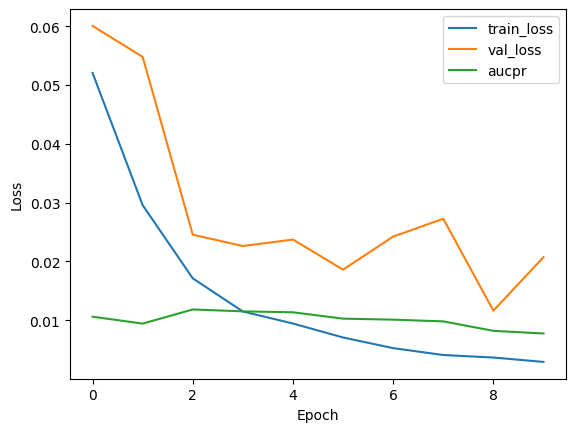

In [36]:
import matplotlib.pyplot as plt
#log = pd.read_csv('model/0811_2042/training_log.csv')
plt.plot(log['train_loss'], label='train_loss')
plt.plot(log['val_loss'], label='val_loss')
plt.plot(log['aucpr'], label='aucpr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Model Evaluation

In [38]:
model.load_state_dict(torch.load(r'model\0814_0309\epoch_10.pth', weights_only=True))

<All keys matched successfully>

In [47]:
# 評估 train 分佈：不用 sampler、不shuffle
train_loader_eval = DataLoader(
    train_ds, batch_size=1024, shuffle=False, num_workers=8, pin_memory=True
)


Performance on Training Set:


Testing: 100%|██████████| 252/252 [01:57<00:00,  2.14it/s]


🔍 Test Loss: 0.0035 | Accuracy: 98.98%
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99    255259
     Failure       0.42      1.00      0.59      1920

    accuracy                           0.99    257179
   macro avg       0.71      0.99      0.79    257179
weighted avg       1.00      0.99      0.99    257179

[[252644   2615]
 [     0   1920]]
ROC AUC: 0.9986


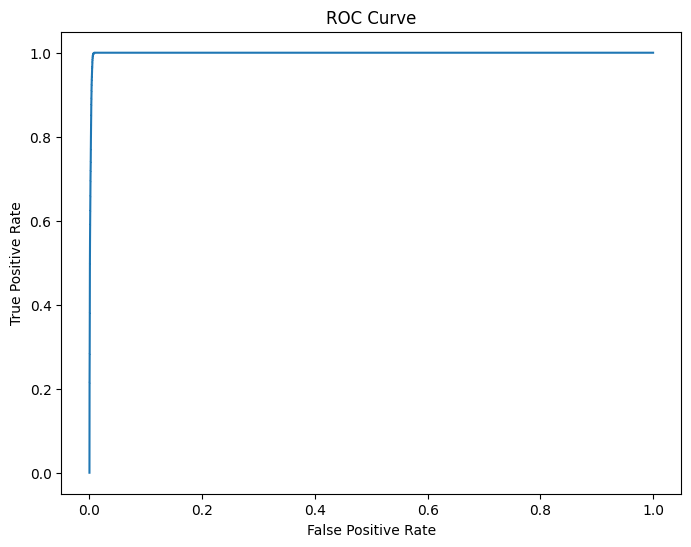

In [48]:
print("Performance on Training Set:")
evaluate_model(model, train_loader_eval, best_threshold=0.5, criterion=criterion)

In [40]:
val_trues, val_predictions, val_outputs = test_loop(model, val_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 66/66 [00:44<00:00,  1.48it/s]

🔍 Test Loss: 0.0207 | Accuracy: 96.18%


(array([49871.,  6205.,  2219.,  1142.,   860.,   608.,   448.,   371.,
          341.,   332.,   325.,   278.,   260.,   250.,   250.,   205.,
          205.,   164.,   156.,   127.,   132.,   142.,   114.,   104.,
          104.,    88.,    62.,    66.,    66.,    58.,    66.,    78.,
           69.,    62.,    57.,    61.,    72.,    86.,    89.,   104.,
          114.,   104.,   114.,   132.,   110.,    96.,   107.,    76.,
          160.,   218.]),
 array([0.01769407, 0.03619042, 0.05468676, 0.0731831 , 0.09167945,
        0.11017579, 0.12867212, 0.14716847, 0.16566481, 0.18416116,
        0.20265749, 0.22115384, 0.23965019, 0.25814652, 0.27664286,
        0.29513922, 0.31363556, 0.33213189, 0.35062823, 0.36912459,
        0.38762093, 0.40611726, 0.4246136 , 0.44310996, 0.46160629,
        0.48010263, 0.49859899, 0.51709533, 0.53559166, 0.554088  ,
        0.57258433, 0.59108067, 0.60957706, 0.62807339, 0.64656973,
        0.66506606, 0.6835624 , 0.70205873, 0.72055507, 0.73905146

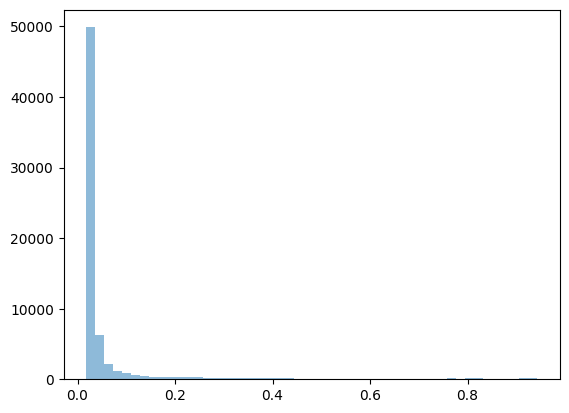

In [41]:
plt.hist(val_outputs, bins=50, alpha=0.5, label='Outputs')

In [42]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresholds = precision_recall_curve(val_trues, val_outputs, pos_label=1)

target_recall = 0.8
idx = next(i for i,r in enumerate(rec) if r < target_recall) - 1
best_threshold = thresholds[idx]
print(f"Threshold for recall ≥ {target_recall}: {best_threshold:.4f}, Precision={prec[idx]:.3f}")


Threshold for recall ≥ 0.8: 0.0242, Precision=0.008


Performance on Validation Set:
              precision    recall  f1-score   support

      Normal       1.00      0.46      0.63     67168
     Failure       0.01      0.80      0.02       360

    accuracy                           0.47     67528
   macro avg       0.50      0.63      0.32     67528
weighted avg       0.99      0.47      0.63     67528

[[31142 36026]
 [   72   288]]
ROC AUC: 0.6435


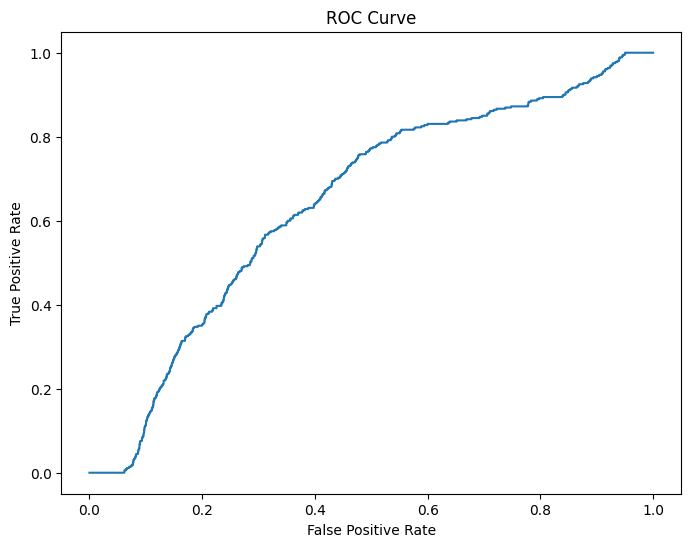

In [43]:
predictions = (val_outputs >= best_threshold).astype(int)
print("Performance on Validation Set:")
generate_report(val_trues, predictions, val_outputs)

In [49]:
test_trues, test_predictions, test_outputs = test_loop(model, test_loader, device='cuda', criterion=criterion)

Testing: 100%|██████████| 65/65 [00:34<00:00,  1.90it/s]

🔍 Test Loss: 0.0254 | Accuracy: 97.82%


(array([5.5882e+04, 4.0220e+03, 1.1100e+03, 8.2100e+02, 6.2000e+02,
        3.5100e+02, 2.3100e+02, 1.8000e+02, 1.6000e+02, 1.4500e+02,
        1.3700e+02, 1.3800e+02, 1.3700e+02, 1.4700e+02, 1.3100e+02,
        9.9000e+01, 9.2000e+01, 6.4000e+01, 7.6000e+01, 6.4000e+01,
        5.7000e+01, 3.9000e+01, 3.4000e+01, 4.3000e+01, 5.3000e+01,
        3.5000e+01, 1.9000e+01, 2.0000e+01, 2.0000e+01, 2.4000e+01,
        1.5000e+01, 1.1000e+01, 1.2000e+01, 1.4000e+01, 1.1000e+01,
        1.8000e+01, 2.2000e+01, 2.1000e+01, 2.5000e+01, 2.9000e+01,
        4.3000e+01, 4.4000e+01, 7.4000e+01, 5.4000e+01, 4.6000e+01,
        4.6000e+01, 5.4000e+01, 8.7000e+01, 8.3000e+01, 9.7000e+01]),
 array([0.01847982, 0.03688544, 0.05529106, 0.07369667, 0.09210229,
        0.11050791, 0.12891352, 0.14731914, 0.16572477, 0.18413039,
        0.202536  , 0.22094162, 0.23934723, 0.25775284, 0.27615848,
        0.2945641 , 0.31296971, 0.33137533, 0.34978095, 0.36818656,
        0.38659218, 0.4049978 , 0.42340341, 0.

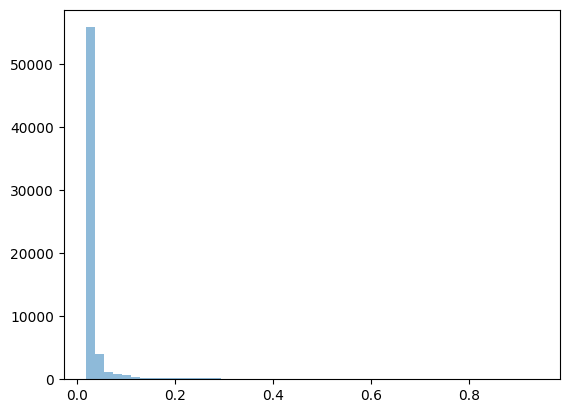

In [50]:
plt.hist(test_outputs, bins=50, alpha=0.5, label='Outputs')

Performance on Test Set:
              precision    recall  f1-score   support

      Normal       0.99      0.47      0.64     65157
     Failure       0.01      0.63      0.02       600

    accuracy                           0.47     65757
   macro avg       0.50      0.55      0.33     65757
weighted avg       0.98      0.47      0.63     65757

[[30757 34400]
 [  222   378]]
ROC AUC: 0.5744


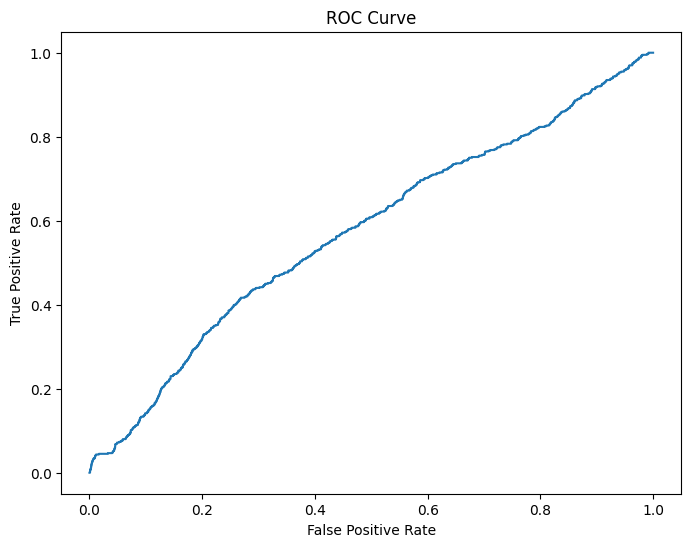

In [52]:
predictions = (test_outputs >= best_threshold).astype(int)
print("Performance on Test Set:")
generate_report(test_trues, predictions, test_outputs)